<a href="https://colab.research.google.com/github/AndrewstheBuilder/ScratchNeuralNet/blob/main/makemore_part5_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## makemore: part 5 (building a WaveNet)

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import requests
%matplotlib inline

In [2]:
# download the names.txt file from github
response = requests.get('https://raw.githubusercontent.com/karpathy/makemore/master/names.txt')
open('names.txt', 'wb').write(response.content)

228145

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


# # These are my notes below:
### Begin

In [11]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
# print('Xb', Xb.shape)
# print('Yb', Yb.shape)
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 10, 15, 14],
        [ 0,  0,  0,  0,  0,  7,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0, 14],
        [ 0,  0,  8,  9, 12, 12,  5, 12]])

In [12]:
model.layers[0].out.shape # output of Embedding layer
# the shape is [4, 8, 24] because there are 4 examples we are looking at
# each example is 8 blocks long. (8 characters to predict the next)
# and each character is represented by a 24 length embedding vector

torch.Size([4, 8, 10])

In [13]:
model.layers[1].out.shape # output of Flatten layer
# the Flatten layer is where we do the view operation to concatenate the vectors
# previously so it would like like .view(4,-1) -> above would become shape [4, 8*24]

torch.Size([4, 4, 20])

In [14]:
model.layers[2].out.shape # output of Linear Layer

torch.Size([4, 4, 200])

In [ ]:
# 1 2 3 4 5 6 7 8
# (1 2) (3 4) (5 6) (7 8)
# we do not want all 8 characters going in at once. Instead we want it to go 2 at a time!
# og Flatten Layer -> (4, 80)
# after change Flatten Layer -> (4, 4, 20)

In [16]:
list(range(10))[1::2] # start at 1 go in steps of 2

[1, 3, 5, 7, 9]

In [17]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get contcatenated
e.view(4, -1).shape # OG Flatten layer operation
e[:, ::2, :], e[:, 1::2, :] # this effectively gets the elements in the even positions, odd positions
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [18]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [20]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [19]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


#### understanding the reduce aspect of torch.mean(input, (dim to reduce over), keepdim)
#### Begin 1


In [24]:
a = torch.rand(4,4,4)
print('a',a)

a tensor([[[0.4016, 0.8352, 0.4928, 0.5208],
         [0.7996, 0.7765, 0.0642, 0.6182],
         [0.0278, 0.4928, 0.5099, 0.2971],
         [0.4668, 0.9838, 0.6362, 0.7533]],

        [[0.9575, 0.7960, 0.0043, 0.9491],
         [0.6425, 0.2815, 0.9890, 0.4787],
         [0.7865, 0.9544, 0.3239, 0.2927],
         [0.9517, 0.0570, 0.0780, 0.3740]],

        [[0.0837, 0.8375, 0.6610, 0.9914],
         [0.6401, 0.3102, 0.1998, 0.5572],
         [0.4418, 0.0494, 0.2815, 0.6364],
         [0.7065, 0.2067, 0.5766, 0.0724]],

        [[0.9399, 0.1058, 0.0184, 0.9275],
         [0.2142, 0.4291, 0.6816, 0.2998],
         [0.1391, 0.2959, 0.2198, 0.8604],
         [0.8152, 0.5881, 0.2012, 0.2514]]])


In [26]:
a.mean((0,1), keepdim=True)


tensor([[[0.5634, 0.5000, 0.3711, 0.5550]]])

#### End 1


### End

In [21]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3178
  10000/ 200000: 2.0952
  20000/ 200000: 2.0468
  30000/ 200000: 2.0679
  40000/ 200000: 1.8782
  50000/ 200000: 2.3732
  60000/ 200000: 2.0859
  70000/ 200000: 2.4602
  80000/ 200000: 1.6482
  90000/ 200000: 2.1333
 100000/ 200000: 2.0251
 110000/ 200000: 1.9648
 120000/ 200000: 2.3486
 130000/ 200000: 2.0984
 140000/ 200000: 2.0250
 150000/ 200000: 2.2575
 160000/ 200000: 2.0519
 170000/ 200000: 2.2428
 180000/ 200000: 1.8414
 190000/ 200000: 2.1077


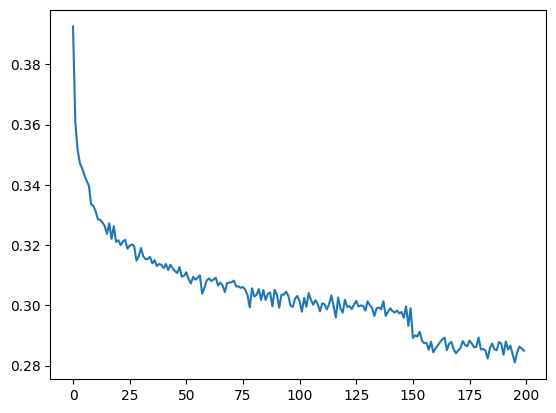

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.9936515092849731


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space